## This script will (hopefully) generate 2D training data from stock prices for a CNN

### Import necessary libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import alpaca_trade_api as tradeapi
import pandas as pd

# Set defaults for plotting
from IPython import display
%matplotlib inline
plt.rcParams['font.size'] = 15
plt.rcParams['figure.figsize'] = (7, 5)

### Define function to produce the gramian angular fields

In [4]:
def gramianAngularField(timeSeries, sumOrDifference='sum'):
    ''' Inputs: 
            timeSeries is a possible pandas column representing the timeSeries you want to transform.
            
            sumOrDifference is a string denoting whether you want the gramian angular summation field or
            the gramian angular difference field
    '''
    N = len(timeSeries)
    
    # If timeSeries is numpy, just reshape, if it's other (pandas dataframe) recast as numpy before reshaping
    if type(timeSeries).__module__ == np.__name__:
        data = timeSeries.reshape(N, -1)
    else:
        data = timeSeries.to_numpy().reshape(N, -1)
        
    # Scale and transform to polar
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaler.fit(data)
    data_scaled = scaler.transform(data)
    phi = np.arccos(data_scaled)  # Remember we don't want to include the radius as this is a form of temporal bias
    
    # Calculate gram angular field in either summation or difference mode
    if sumOrDifference in ['sum', 'Sum', '+']:
        # 'Dot' product across all the transformed representations in this series
        gram = np.vectorize(lambda x,y: np.cos(x + y))(*np.meshgrid(phi, phi, sparse=True))
    else:
        gram = np.vectorize(lambda x,y: np.sin(x + y))(*np.meshgrid(phi, phi, sparse=True))
    # Note - plot the gram with plt.imshow(gram) to get it to look like it should
    
    return gram

### Define constants

In [26]:
key_dir = 'C:\\Users\\Dan\\Documents\\Python Scripts\\apiKeys\\'
apiKey = open(key_dir + 'alpaca_apiKey.txt', 'r').read()
secretKey = open(key_dir + 'alpaca_secretKey.txt', 'r').read()
endPoint = 'https://paper-api.alpaca.markets'  # Specify this for demo account

# Define the companies you want the data for
tickers = ['AAPL', 'MSFT']

# Define dates and time window
startDate = '2020-01-01'
endDate = '2020-05-28'
timeWindow = 20

# Connect to the API and pull the data
api = tradeapi.REST(apiKey, secretKey, endPoint, api_version='v2')

### Interface with the brokerage

In [5]:
# Define the dictionary that will hold all the data for all the companies
ohlcv = {}
for ticker in tickers:
    try:
        # Pull the stock details for that ticker
        ohlcv[ticker] = api.get_aggs(ticker, 1, 'day', startDate, endDate).df
        # Calculate their daily return
        ohlcv[ticker]['daily return'] = ohlcv[ticker]['close'].pct_change()
        print('Pulling ohlcv data for {:s}'.format(ticker))
    except:
        # If nothing is found, throw error and continue
        print('Error encountered pulling ohlcv data for {:s}'.format(ticker))

Pulling ohlcv data for AAPL
Pulling ohlcv data for MSFT


### Loop over the data and for each time window extract a gramian angular field

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


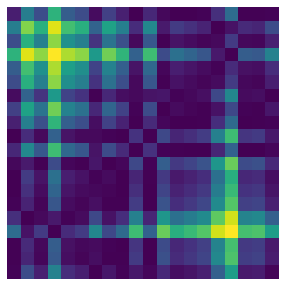

In [47]:
# 1 for save data, 0 for no saving, only plotting for inspection
saveToFile = 1
# 40 of these gram fields at windowSize=20 is about 200kb

for i in range(2*timeWindow):
    data = ohlcv['AAPL']['close'].iloc[i:i+timeWindow].to_numpy().reshape(timeWindow, -1)
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaler.fit(data)
    data_scaled = scaler.transform(data)
    phi = np.arccos(data_scaled)
    gram = np.vectorize(lambda x,y: np.cos(x + y))(*np.meshgrid(phi, phi, sparse=True))

    if saveToFile == 1:
        
        fig1 = plt.gcf()
        plt.imshow(gram)
        plt.axis(False)
        plt.draw()
        display.clear_output(wait=True)
        fileName = 'gramian_' + str(i)
        plt.savefig('./trainingData_Gramian/' + fileName + '.png', dpi=100, frameon=False, bbox_inches='tight', pad_inches=0)
        
    else:
            
        plt.figure(figsize=(15,6), num=1)

        # Plot the time series
        plt.subplot(1, 2, 1)
        plt.plot(data_scaled)
        plt.gcf().autofmt_xdate()
        plt.title('Scaled close price')

        # Plot the gramian angular summation field
        plt.subplot(1, 2, 2)
        plt.imshow(gram)
        plt.axis(False)
        plt.title('Gramian angular summation field')

        # Update the plot(s)
        display.clear_output(wait=True)
        plt.pause(0.5)

Check if you want these fields to use overlapping data

### Code for saving a figure to a file in the cwd

In [25]:
#fig1 = plt.gcf()
#plt.plot(ohlcv['AAPL']['close'])
#plt.draw()
#plt.savefig('./trainingData_Gramian/test.png', dpi=100)